# Importing Libraries

In [1]:
import numpy as np
import pickle
import os
import re  # regex
import matplotlib.pyplot as plt
from IPython import display
from struct import unpack
from datetime import datetime

# Defining Constants

In [2]:
# list of colors for plotting
COLOR_LIST = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4', '#58e03d']

In [3]:
NUM_TRAIN_MAX = 60000  # number of examples in the MNIST training set
NUM_TEST_MAX = 10000   # number of examples in the MNIST test set
IMG_SIZE = 28          # each image has size of 28x28
INP_LENGTH = 784       # size of image after straightened up
NUM_CLASS = 10         # number of classes to make prediction on

num_train_load = 60000  # number of training examples to load
num_test_load = 10000   # number of test examples to load

path_to_dataset = 'datasets'

## 1.1. Loading Data

In [4]:
def load_images(set_type, num_example=None):
    """
    Load images of handwritten digits
    :param str set_type: train/test
    :param int num_example: number of images to read
    :return: matrix of images, each image is a vector of ints in [0, 255]
    :rtype: np_array<int>[num_example, INP_LENGTH]
    """
    
    # get set to load from
    if set_type == "train":
        file_name = path_to_dataset+"/train-images.idx3-ubyte"
        if num_example is None: num_example = NUM_TRAIN_MAX  # read all
    else:
        file_name = path_to_dataset+"/t10k-images.idx3-ubyte"
        if num_example is None: num_example = NUM_TEST_MAX  # read all

    # load images from file
    with open(file_name, "rb") as fi:

        # these numbers are not used and are assigned manually
        fi.read(4)  # magic number, not used
        fi.read(4)  # num_row - number of images
        fi.read(4)  # size - number of rows
        fi.read(4)  # size - number of columns
        
        # load each image from binary data
        image_list = []
        for i in range(num_example):
            image = []
            for pi in range(INP_LENGTH):
                pixel = unpack('B', fi.read(1))[0]
                image.append(pixel)
            image_list.append(image)

    return np.array(image_list)


def load_labels(set_type, num_example=None):
    """
    Load labels of images
    :param str set_type: train/test
    :param int num_example: number of labels to read
    :return: vector of labels, each label is an int in [0, 9]
    :rtype: np_array<int>[num_example,]
    """

    # get set to load from
    if set_type == "train":
        file_name = path_to_dataset+"/train-labels.idx1-ubyte"
        if num_example is None: num_example = NUM_TRAIN_MAX  # read all
    else:
        file_name = path_to_dataset+"/t10k-labels.idx1-ubyte"
        if num_example is None: num_example = NUM_TEST_MAX  # read all

    # load labels from file
    with open(file_name, "rb") as fi:

        # these numbers are not used and are assigned manually
        fi.read(4)  # magic number, not used
        fi.read(4)  # num_row - number of labels

        # load each label from binary data
        label_list = []
        for i in range(num_example):
            label = unpack('B', fi.read(1))[0]
            label_list.append(label)

    return np.array(label_list)


def load_data_set(set_type, num_example=None):
    """
    Load images and labels
    :param str set_type: train/test
    :param int num_example: number of examples to read
    :return: images list, labels list
    :rtype: np_array<int>[num_example, INP_LENGTH], np_array<int>[num_example,]
    """
    
    return load_images(set_type, num_example=num_example), load_labels(set_type, num_example=num_example)

In [5]:
train_x, train_y = load_data_set('train', num_example=num_train_load)
test_x, test_y = load_data_set('test', num_example=num_test_load)

## 1.2. Analyzing

### 1.2.1. Understanding Data

In [7]:
print("train_x.shape = {}".format(train_x.shape))
print("train_y.shape = {}".format(train_y.shape))
print("test_x.shape = {}".format(test_x.shape))
print("test_y.shape = {}".format(test_y.shape))

train_x.shape = (60000, 784)
train_y.shape = (60000,)
test_x.shape = (10000, 784)
test_y.shape = (10000,)


In [8]:
print("Sample image:")
print(train_x[0])
print("Sample labels:")
print(train_y[ : 30])

Sample image:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 253 253 198 182 247 241   0 

### 1.2.3. Data Distribution

In [22]:
def plot_distribution(data_y_train, data_y_test):
    """
    Plot data distribution for training and test set
    :param np_array<int>[n,] data_y_train: labels of training set
    :param np_array<int>[n,] data_y_test: labels of test set
    :return: None
    """
    
    # setup figure & axes
    subplot_kw=dict(xlabel='Label', ylabel='Count', ylim=(0, len(data_y_train)/8))
    gridspec_kw=dict(left=0, right=1, top=1, bottom=0, hspace=0.1)
    fig, axes = plt.subplots(nrows=1, ncols=2, subplot_kw=subplot_kw, gridspec_kw=gridspec_kw, figsize=(14, 4))
    
    # plot distribution for training set
    unique_list, count_list = np.unique(data_y_train, return_counts=True)
    axes[0].bar(np.arange(len(unique_list)), count_list, tick_label=unique_list, color=COLOR_LIST)
    axes[0].set_title('Training Set')

    # plot distribution for test set
    unique_list, count_list = np.unique(data_y_test, return_counts=True)
    axes[1].bar(np.arange(len(unique_list)), count_list, tick_label=unique_list, color=COLOR_LIST)
    axes[1].set_title('Test Set')
    
    plt.show()

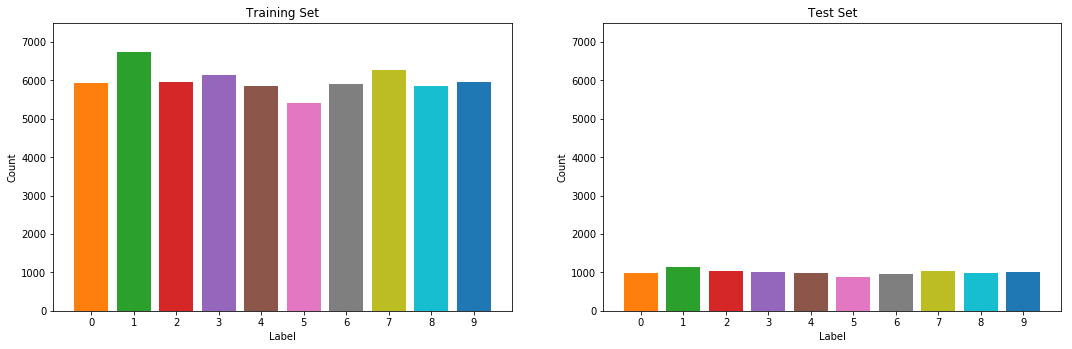

In [23]:
plot_distribution(train_y, test_y)

## 1.3. Data Preprocessing

In [16]:
def scale_x(data_x):
    """
    Apply feature scaling for input set so that each pixel falls in range [-1, 1]
    :param np_array<int>[n, INP_LENGTH] data_x: input set
    :return: input set after scaled
    :rtype: np_array<int>[n, INP_LENGTH]
    """
    
    return (data_x/255)*2 - 1

In [17]:
train_x = scale_x(train_x)
test_x = scale_x(test_x)

In [18]:
print("Sample input after scaled:")
print(train_x[0])

Sample input after scaled:
[-1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314
 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314
 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314
 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314
 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314
 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314
 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314
 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314
 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314
 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314
 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314
 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314
 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314 -1.00784314
 -1.00784314 -1.00784314

# 2. Model - Neural Network

## 2.1. Supporting Functions

### 2.1.1. Activation Functions

Sigmoid:

\begin{equation}
S(x) = \frac{1}{1+e^{-x}}
\end{equation}

\begin{equation}
S(z)_i = \frac{1}{1+e^{-z_i}}
\end{equation}

Softmax:

\begin{equation}
\sigma(z)_i = \frac{e^{z_i}}{\sum^n_{j=1}e^{z_j}}
\end{equation}

In [19]:
def sigmoid(z):
    """
    Sigmoid activation function
    :param np_array<float>[1, n] z: output of a layer that has not been activated 
    :return: activated output
    :rtype: np_array<float>[1, n]
    """

    return 1/(1+np.exp(-z))


def softmax(z):
    """
    Softmax activation function
    :param np_array<float>[1, n] z: output of a layer that has not been activated 
    :return: activated output
    :rtype: np_array<float>[1, n]
    """
    
    exp_arr = np.exp(z)
    sum = np.sum(exp_arr)
    return exp_arr/sum

### 2.1.2. Derivative of Activation Functions

Derivative of Sigmoid:

\begin{equation}
S'(x) = \frac{e^{-x}}{(1+e^{-x})^2} = S(x)(1-S(x))
\end{equation}

\begin{equation}
S'(a)_i = \frac{e^{-a_i}}{(1+e^{-a_i})^2} = S(a_i)(1-S(a_i))
\end{equation}

In [20]:
def sigmoid_derv(a):
    """
    Derivative of sigmoid activation function
    :param np_array<float>[1, n] a: output of a layer that has been activated 
    :return: derivative of softmax activation function
    :rtype: np_array<float>[1, n]
    """
    
    return np.multiply(a, 1-a)

### 2.1.3. Processing Functions
One-hot encoder:<br>
0 => [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]<br>
5 => [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]<br>
9 => [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [21]:
def make_one_hot(y):
    """
    Make one-hot encoder array from label
    :param int y: a single label
    :return: one-hot encoder array
    :rtype: np_array<int>[NUM_CLASS,]
    """
    
    one_hot = np.zeros(NUM_CLASS)
    one_hot[y] = 1
    return one_hot

## 2.2. Model: Classifier Class

Feed-forward:

\begin{align}
z^{(l)} & = \big(bias+a^{(l-1)}\big).W^{(l-1)} \\
a^{(l)} & = activation^{(l)}\big(z^{(l)}\big) \\\\
a^{(0)} & = x = \text{input} \\
z^{(1)} & = \big([1]+a^{(0)}\big).W^{(0)} \\
a^{(1)} & = S\big(z^{(1)}\big) = \text{hidden layer} \\
z^{(2)} & = \big([1]+a^{(1)}\big).W^{(1)} \\
a^{(2)} & = \sigma\big(z^{(2)}\big) = \hat{y} = \text{output}
\end{align}

Loss function: Cross-entropy

\begin{align}
J(W) & = -\sum_{k=0}^{9} y_k \log\hat{y}_k \tag{for one example} \\
J(W) & = -\frac{1}{n}\sum_{i=0}^{n-1}\sum_{k=0}^{9} y^{(i)}_k \log\hat{y}^{(i)}_k \tag{for the entire dataset}
\end{align}

Backpropagation:

\begin{eqnarray}
\delta^{(L)} &=& \frac{\partial J}{\partial z^{(L)}} = \frac{\partial J}{\partial a^{(L)}}\frac{\partial a^{(L)}}{\partial z^{(L)}} &=& a^{(L)}-y \\
\delta^{(l)} &=& \frac{\partial J}{\partial z^{(l)}} = \bigg(\frac{\partial J}{\partial z^{(l+1)}}W^{(l)T}\bigg)\frac{\partial a^{(l)}}{\partial z^{(l)}} &=& \bigg(\delta^{(l+1)}W^{(l)T}\bigg)\frac{\partial activation^{(l)}\big(z^{(l)}\big)}{\partial z^{(l)}} \\
\frac{\partial J}{\partial W^{(l)}} &=& \big(bias+a^{(l)T}\big)\frac{\partial J}{\partial z^{(l+1)}} &=& \big(bias+a^{(l)T}\big)\delta^{(l+1)} \\
\end{eqnarray}
<br>
<br>
\begin{align}
\delta^{(2)} & = a^{(2)}-y = \hat{y}-y = output-y \\
\frac{\partial J}{\partial W^{(1)}} & = \big([1]+a^{(1)T}\big)\delta^{(2)} \\
\delta^{(1)} & = \big(\delta^{(2)}W^{(1)T}\big)\frac{\partial S\big(z^{(1)}\big)}{\partial z^{(1)}} \\
\frac{\partial J}{\partial W^{(0)}} & = \big([1]+a^{(0)T}\big)\delta^{(1)}
\end{align}

Update weights:

\begin{equation}
W^{(i)} = W^{(i)} - \alpha\frac{\partial J}{\partial W^{(i)}}
\end{equation}

<br>
The flow of back propagation: http://neuralnetworksanddeeplearning.com/chap2.html#the_backpropagation_algorithm

In [22]:
class HDClassifierNN:
    """
    Handwritten digits classifier using Neural Network model
    Layers: [INPUT_LENGTH, hidden_layer_size, 10]
    Learning rate: learning_rate
    Loss function: Cross-entropy
    Optimization method: Stochastic Gradient Descent
    """
    
    def __init__(self, hidden_layer_size, learning_rate):
        """
        Initialize model
        :param int hidden_lay_size: number of nodes in the hidden layer
        :param float learning_rate: the learning rate alpha
        :return: None
        """
        
        # set layers, learning rate & other attributes
        self.layer_list = [INP_LENGTH, hidden_layer_size, 10]
        self.learning_rate = learning_rate
        self.w_list = []
        self.trained_epochs = 0
        self.loss_list = [[], []]
        
        # random weights in range [-1, 1]
        for i in range(len(self.layer_list) - 1):
            self.w_list.append(np.random.rand(self.layer_list[i]+1, self.layer_list[i+1])*2-1)
            
            
    def predict(self, x):
        """
        Give posibility for each class
        :param np_array<float>[1, INP_LENGTH] x: input for the network
        :return: list of posibility for each class
        :rtype: np_array<float>[1, NUM_CLASS]
        """
        
        # input layer
        a = x
        
        # hidden layer
        a = np.append([[1]], a, axis=1)   # add bias
        z = np.matmul(a, self.w_list[0])  # get output from layer
        a = sigmoid(z)                    # apply activation function
        
        # output layer
        a = np.append([[1]], a, axis=1)   # add bias
        z = np.matmul(a, self.w_list[1])  # get output from layer
        a = softmax(z)                    # apply activation function
        
        return a
    
    
    def predict_class(self, x):
        """
        Give predicted class and certainty on the prediction
        :param np_array<float>[1, INP_LENGTH] x: input for the network
        :return: predicted_class, certainty
        :rtype: int, float
        """
        
        prediction = self.predict(x)[0]
        certainty = np.amax(prediction)
        predicted_class = np.where(prediction == certainty)[0][0]
        return predicted_class, certainty
            
    
    def feed_forward(self, x):
        """
        Perform feed-forward for neural network
        :param np_array<float>[1, INP_LENGTH] x: input for the network
        :return: list of outputs for every layers, including x
        :rtype: list<np_array<float>[1, length_of_each_layer]>[number_of_layers]
        """
        
        # input layer
        a = x
        output_list = [a]                 # add input to output_list
        
        # hidden layer
        a = np.append([[1]], a, axis=1)   # add bias
        z = np.matmul(a, self.w_list[0])  # get output from layer
        a = sigmoid(z)                    # apply activation function
        output_list.append(a)             # add output of the layer to output_list
        
        # output layer
        a = np.append([[1]], a, axis=1)   # add bias
        z = np.matmul(a, self.w_list[1])  # get output from layer
        a = softmax(z)                    # apply activation function
        output_list.append(a)             # add output of the layer to output_list

        return output_list
        
    
    def cal_loss(self, prediction, label):
        """
        Calculate cross-entropy loss for a single prediction
        :param np_array<float>[1, NUM_CLASS] prediction:
            prediction returned by self.predict() or self.feed_forward()[-1]
        :param int label: label
        :return: loss for the single prediction
        :rtype: float
        """

        return -np.log(prediction[0][label])
    
    
    def cal_loss_set(self, data_x, data_y):
        """
        Calculate cross-entropy loss when predicting on inputted set
        :param np_array<int>[n, INP_LENGTH] data_x: input set
        :param np_array<int>[n,] data_y: label set
        :return: loss on the inputted set
        :rtype: float
        """
        
        total_loss = 0
        # calculate loss for each prediction then add to total_loss
        for i in range(len(data_y)):
            prediction = self.predict(data_x[i].reshape(1, 784))
            total_loss += self.cal_loss(prediction, data_y[i])
        loss = total_loss / len(data_y)  # loss is average loss of a prediction
        return loss
    
    
    def backpropagate(self, output_list, label):
        """
        Perform backpropagation for neural network
        :param list<np_array<float>[1, length_of_each_layer]>[number_of_layers] output_list:
            list of outputs for every layers, including input layer, returned by self.feed_forward()
        :param int label: label
        :return: list of derivatives for updating weights
        :rtype: list<np_array<float>[length_of_layer[i]+1, length_of_layer[i+1]]>[number_of_layers-1]
        """
        
        # output layer
        delta = output_list[-1] - make_one_hot(label)                         # get "error" of the output layer
        derv = np.matmul(np.append([[1]], output_list[-2].T, axis=0), delta)  # get derivative
        derv_list = [derv]                                                    # add derivative to derv_list
        
        # hidden layer
        activation_derv = sigmoid_derv(output_list[-2])                         # get derivative of the activation function
        delta = np.multiply(np.matmul(delta, self.w_list[-1][1: , : ].T), activation_derv)  # get "error" of the layer
        derv = np.matmul(np.append([[1]], output_list[-3].T, axis=0), delta)                # get derivative of loss function
        derv_list.insert(0, derv)                                                           # add derivative to grad_list
        
        return derv_list
    
    
    def update_weights(self, derv_list):
        """
        Update weights to minimize loss function
        :param list<np_array<float>[length_of_layer[i]+1, length_of_layer[i+1]]>[number_of_layers-1] derv_list:
            list of derivatives for updating weights, returned by self.backpropagate()
        :return: None
        """
        
        for i in range(len(self.w_list)):
            self.w_list[i] = self.w_list[i] - self.learning_rate*derv_list[i]
    
    
    def plot_losses(self, start_time=None):
        """
        Plot loss history on training and test set
        :param datetime.datetime start_time: time when starting training
        :return: None
        """
        
        fig = plt.figure(figsize=(16, 5))
#         ax = plt.subplot(xlabel='100 examples', ylabel='Loss', title='Losses', xlim=(0, len(self.loss_list[0])), ylim=(0, 5))
        ax = plt.subplot(xlabel='100 examples', ylabel='Loss', title='Losses', xlim=(0, len(self.loss_list[0])))
        ax.plot(self.loss_list[0], label='Train | {0:.2f}'.format(self.loss_list[0][-1]))
        ax.plot(self.loss_list[1], label='Test | {0:.2f}'.format(self.loss_list[1][-1]))
        if start_time is not None:
            ax.text(0, -0.7, 'Time elapsed: {}'.format(datetime.utcnow()-start_time))
        ax.legend()

# 3. Training Model

## 3.1. Defining Functions

In [23]:
def save_model(model):
    """
    Save model to saved-models directory. Model is named the timestamp when saving.
    :param HDClassifierNN model: model to save
    :return: None
    """
    
    file_name = 'model-{}.pickle'.format(int(datetime.utcnow().timestamp()))
    with open('saved-models/{}'.format(file_name), 'wb') as fo:
        pickle.dump(model, fo)
    print('Model saved to saved-models/{}'.format(file_name))

In [24]:
def train(model, num_epoch, data_x_train, data_y_train, data_x_test, data_y_test, save=True):
    """
    Train given model
    :param HDClassifierNN model: model to train
    :param int num_epoch: number of epochs to train
    :param np_array<int>[n, INP_LENGTH] data_x_train: inputs of training set
    :param np_array<int>[n,] data_y_train: labels of training set
    :param np_array<int>[n, INP_LENGTH] data_x_test: inputs of test set
    :param np_array<int>[n,] data_y_test: labels of test set
    :param bool save: save model after training or not
    :return: None
    """

    # start of training
    start_time = datetime.utcnow()
    
    # train for a specified number of epochs
    for epoch in range(num_epoch):

        # train the model on the training set using stochastic gradient descent
        for i in range(len(data_y_train)):
            
            # perform feed-forward and backpropagation
            model.trained_epochs += 1  # update number of epochs trained
            output_list = model.feed_forward(data_x_train[i].reshape(1, 784))  # perform feed-forward
            print(output_list)
            grad_list = model.backpropagate(output_list, data_y_train[i])  # use results from feed-forward to calculate gradients
            model.update_weights(grad_list)                                # update weights based on gradients

            # plot & save losses for each 100 examples trained
            if i % 100 == 0:
                
                # get losses
                train_loss = model.cal_loss_set(data_x_train, data_y_train)  # get loss for training set
                test_loss = model.cal_loss_set(data_x_test, data_y_test)     # get loss for test set
                model.loss_list[0].append(train_loss)
                model.loss_list[1].append(test_loss)

                # plot losses update while training
                display.clear_output(wait=True)
                model.plot_losses(start_time=start_time)
                plt.show()
                
    # save model
    if save:
        save_model(model)

## 3.2. Training & Saving

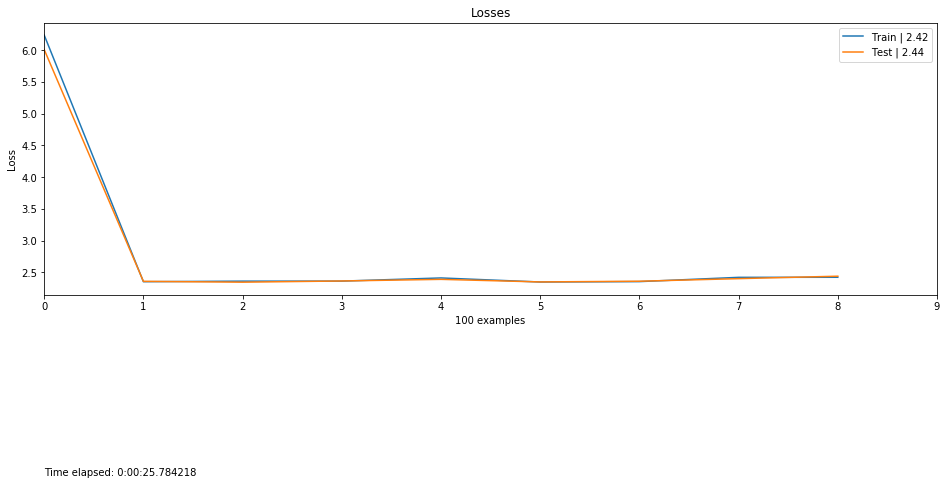

[array([[-1.00784314, -1.00784314, -1.00784314, -1.00784314, -1.00784314,
        -1.00784314, -1.00784314, -1.00784314, -1.00784314, -1.00784314,
        -1.00784314, -1.00784314, -1.00784314, -1.00784314, -1.00784314,
        -1.00784314, -1.00784314, -1.00784314, -1.00784314, -1.00784314,
        -1.00784314, -1.00784314, -1.00784314, -1.00784314, -1.00784314,
        -1.00784314, -1.00784314, -1.00784314, -1.00784314, -1.00784314,
        -1.00784314, -1.00784314, -1.00784314, -1.00784314, -1.00784314,
        -1.00784314, -1.00784314, -1.00784314, -1.00784314, -1.00784314,
        -1.00784314, -1.00784314, -1.00784314, -1.00784314, -1.00784314,
        -1.00784314, -1.00784314, -1.00784314, -1.00784314, -1.00784314,
        -1.00784314, -1.00784314, -1.00784314, -1.00784314, -1.00784314,
        -1.00784314, -1.00784314, -1.00784314, -1.00784314, -1.00784314,
        -1.00784314, -1.00784314, -1.00784314, -1.00784314, -1.00784314,
        -1.00784314, -1.00784314, -1.00784314, -1.

KeyboardInterrupt: 

In [25]:
# define training configs
num_epoch = 1     # number of epochs to train
num_train = 6000  # number of training examples
num_test = 2000   # number of test examples
save = True        # save model after training or not

# initialize model
hidden_layer_size = 100
learning_rate = 0.01
model = HDClassifierNN(hidden_layer_size, learning_rate)

# train
train(model, num_epoch, train_x[ :num_train, : ], train_y[ :num_train], test_x[ :num_test, : ], test_y[ :num_test], save=save)

# 4. Loading Model (Optional)
Load trained model from file. Use this when loading trained model to make prediction, evaluate or countinue training.

In [30]:
def load_model(name=None):
    """
    Load model from saved-models directory
    :param str name: name of the model, load most recent model with timestamp in name if not specified
    :return: loaded model
    :rtype: HDClassifierNN
    """
    
    # if name not specified: get the most recent model with timestamp in name
    if name is None:
        name = ''
        for r, d, f in os.walk('saved-models'):
            for file_name in f:
                if re.search('model-\d{10}\.pickle', file_name) is not None and file_name > name:
                    name = file_name
        if name == '':
            print("No model with timestamp found")
            return None
    # else: get model with name 'model-name.pickle'
    else:
        name = 'model-{}.pickle'.format(name)
    
    # load model from pickle file
    with open('saved-models/{}'.format(name), 'rb') as fi:
        model = pickle.load(fi)
    print("Model loaded from {}".format(name))
              
    return model

In [44]:
model = load_model('3-60000-10000')  # the name means trained with 3 epoch,
                                     # on 60000 training examples
                                     # and tested on 10000 examples

NameError: name 'load_model' is not defined

In [20]:
model = load_model('model-1618715277')

Model loaded from model-1618715277.pickle


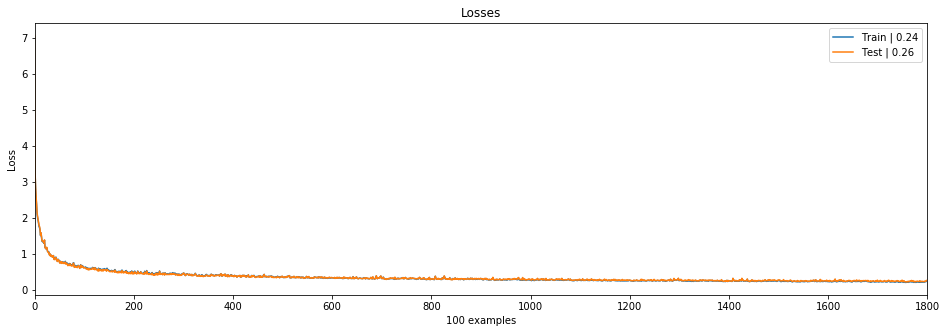

In [34]:
model.plot_losses()

# 5. Evaluation

## 5.1. Getting Predictions

### 5.1.1. Single Prediction

In [22]:
def show_prediction(model, data_x, data_y, show_class=None):
    """
    Show prediction for a random example in inputted set
    :param HDClassifierNN model: model used to make prediction
    :param np_array<int>[n, INP_LENGTH] data_x: input set
    :param np_array<int>[n,] data_y: label set
    :param int show_class: a specific class of the example
    :return: None
    """
    
    # extract only example with class == show_class
    if show_class != None:
        data_x = data_x[data_y==show_class]
    
    # get random example from inputted set
    random_idx = np.random.randint(len(data_y))
    x = data_x[random_idx]
    y = data_y[random_idx]
        
    # get prediction
    prediction = model.predict(x.reshape(1, 784))[0]
    predicted_class, certainty = model.predict_class(x.reshape(1, 784))
    
    # setup fig & axes
    gridspec_kw=dict(left=0, right=1, top=0.92, bottom=0, wspace=0.05, hspace=0.25, width_ratios=[2, 1])
    fig, axes = plt.subplots(nrows=1, ncols=2, gridspec_kw=gridspec_kw, figsize=(10, 3))

    # plot prediction vector
    axes[0].bar(np.arange(NUM_CLASS), prediction*100, tick_label=range(10), color=COLOR_LIST)
    axes[0].set_ylim(0, 100)
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Certainty (%)')
    axes[0].set_title('Prediction')
    axes[0].text(8, 90, '{} | '.format(predicted_class) + '{0:.2f}%'.format(certainty*100), fontsize=12)

    # plot image
    axes[1].imshow(np.reshape(x, (IMG_SIZE, IMG_SIZE)), cmap='gray')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
        
    plt.show()

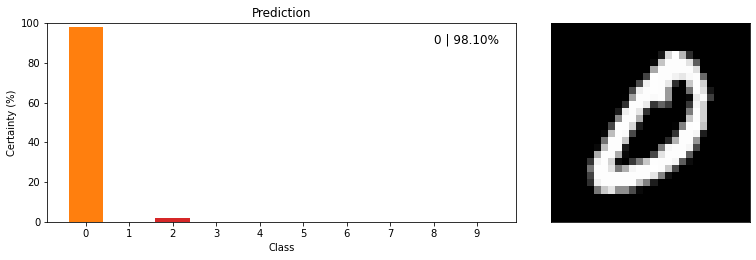

In [23]:
show_prediction(model, train_x, train_y)

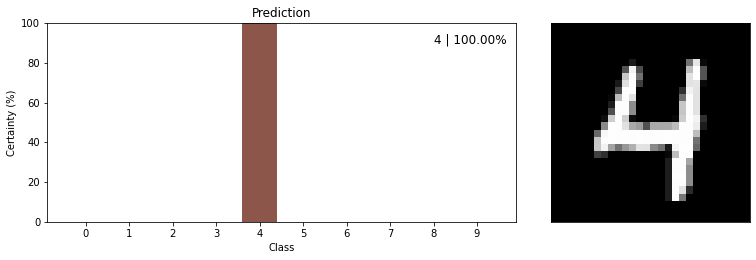

In [24]:
show_prediction(model, test_x, test_y)

### 5.1.2. Multiple Predictions
Call model multiple times to predict.

In [35]:
def show_predictions(model, data_x_train, data_y_train, data_x_test, data_y_test, show_class=None):
    """
    Show multiple predictions for random examples in training and test set
    :param HDClassifierNN model: model used to make prediction
    :param np_array<int>[n, INP_LENGTH] data_x_train: inputs of training set
    :param np_array<int>[n,] data_y_train: labels of training set
    :param np_array<int>[n, INP_LENGTH] data_x_test: inputs of test set
    :param np_array<int>[n,] data_y_test: labels of test set
    :param int show_class: a specific class of the examples
    :return: None
    """

    # select examples to show
    if show_class != None:
        data_x_train = data_x_train[data_y_train == show_class]
        data_y_train = data_y_train[data_y_train == show_class]
        data_x_test = data_x_test[data_y_test == show_class]
        data_y_test = data_y_test[data_y_test == show_class]
    
    # specify number of rows and columns to plot
    num_row = 5
    num_col = 4
    
    # setup fig & axes
    subplot_kw=dict(xticks=[], yticks=[])
    gridspec_kw=dict(left=0, right=1, top=0.92, bottom=0, wspace=0.05, hspace=0.25, width_ratios=[2, 1]*num_col)
    fig, axes = plt.subplots(nrows=5, ncols=8, subplot_kw=subplot_kw, gridspec_kw=gridspec_kw, figsize=(14, 6.6))
    
    # plot predictions & images
    for i in range(num_row):  # plot each row
        for j in range(2):    # plot each dataset
            for k in range(num_col//2):  # plot each column
            
                # get random example
                if j == 0:
                    random_idx = np.random.randint(len(data_y_train))
                    x = data_x_train[random_idx]
                    y = data_y_train[random_idx]
                else:
                    random_idx = np.random.randint(len(data_y_test))
                    x = data_x_test[random_idx]
                    y = data_y_test[random_idx]
                    
                # get prediction
                prediction = model.predict(x.reshape(1, 784))[0]
                predicted_class, certainty = model.predict_class(x.reshape(1, 784))

                # plot prediction
                axes[i, j*num_col+k*2].bar(np.arange(NUM_CLASS), prediction*100, tick_label=range(10), color=COLOR_LIST)
                axes[i, j*num_col+k*2].set_ylim(0, 100)
                axes[i, j*num_col+k*2].text(6, 80, '{} | '.format(predicted_class) + '{0:.2f}%'.format(certainty*100))

                # plot image
                axes[i, j*num_col+k*2+1].imshow(np.reshape(x, (IMG_SIZE, IMG_SIZE)), cmap='gray')
    
    # set labels and notes
    fig.suptitle("Predictions on Random Examples of Training & Test Set", y=1, fontsize=14)
    for i in range(num_col//2):
        axes[0, i*2].set_title('Train')
        axes[0, i*2+num_col].set_title('Test')
    for i in range(num_col):
        axes[num_row-1, i*2].set_xlabel('Class')
    for i in range(num_row):
        axes[i, 0].set_ylabel('Certainty (%)')
        
    plt.show()

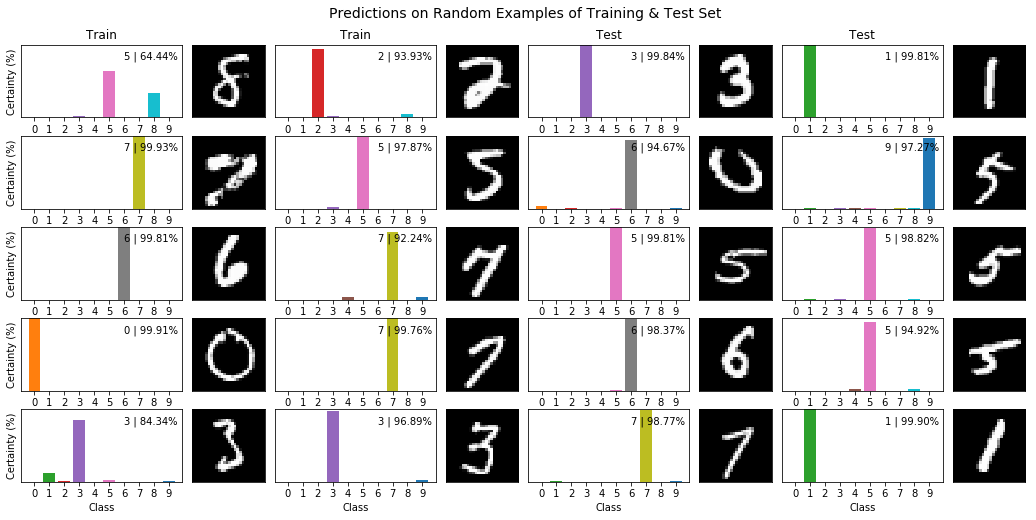

In [37]:
show_predictions(model, train_x, train_y, test_x, test_y)

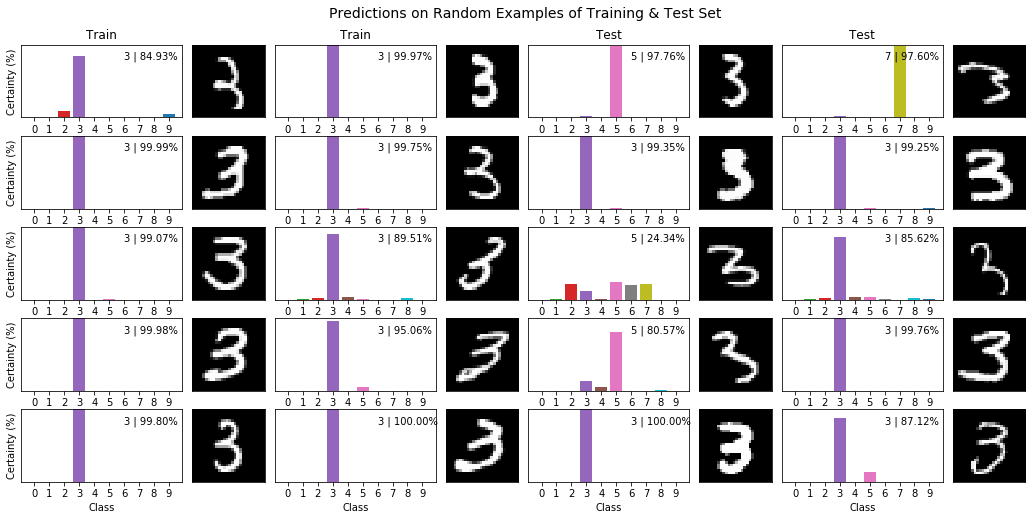

In [33]:
show_predictions(model, train_x, train_y, test_x, test_y, show_class=3)

## 5.2. Evaluating Metrics

### 5.2.1. Accuracy

In [25]:
def cal_accuracy(model, data_x, data_y):
    """
    Calculate accuracy score of model on inputted set 
    :param HDClassifierNN model: model used to make prediction
    :param np_array<int>[n, INP_LENGTH] data_x: input set
    :param np_array<int>[n,] data_y: label set
    :return: accuracy score
    :rtype: float
    """
    
    correct_count = 0
    for i in range(len(data_y)):
        predicted_class, _ = model.predict_class(data_x[i].reshape(1, 784))
        correct_count += predicted_class == data_y[i]
    return correct_count / len(data_y)

In [26]:
def plot_accuracy(acc_train, acc_test):
    """
    Plot accuracy score of model on training and test set
    :param float acc_train: accuracy score on training set
    :param float acc_test: accuracy score on test set
    :return: None
    """
    
    # setup figure & axes
    fig = plt.figure(figsize=(3, 5))
    axe = plt.subplot(title='Accuracy on Training & Test Set', ylim=[0, 100], xlabel='Dataset', ylabel='Accuracy (%)')
    
    # plot accuracies for
    axe.bar(np.arange(2), [acc_train, acc_test], tick_label=['Train', 'Test'], color=COLOR_LIST)
    
    plt.show()

Accuracy on training set: 90.30166666666666%
Accuracy on test set: 90.18%


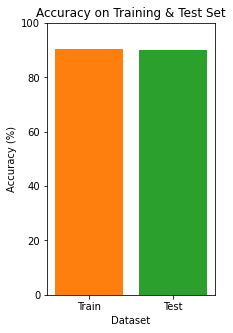

In [27]:
acc_train = cal_accuracy(model, train_x, train_y)*100
acc_test = cal_accuracy(model, test_x, test_y)*100

print("Accuracy on training set: {}%".format(acc_train))
print("Accuracy on test set: {}%".format(acc_test))

plot_accuracy(acc_train, acc_test)

### 5.2.2. Accuracy for Each Class

In [40]:
def predicted(model, data_x):
    predicted_list = []
    for i in range(len(data_x)):
        predicted_class, _ = model.predict_class(data_x[i].reshape(1, 784))
        predicted_list.append(predicted_class)

    return predicted_list


predicted_list = np.array(predicted(model, train_x))

In [53]:
def cal_accuracy_class(model, data_x, data_y):
    """
    Calculate accuracy score of model for each class on inputted set 
    :param HDClassifierNN model: model used to make prediction
    :param np_array<int>[n, INP_LENGTH] data_x: input set
    :param np_array<int>[n,] data_y: label set
    :return: accuracy score for each class
    :rtype: np_array<float>[NUM_CLASS]
    """
    
    acc_list = []
    
    for c in range(NUM_CLASS):
        correct_count = 0
        FP_count = 0
        FN_count = 0
        TN_count = 0
        for i in range(len(data_y)):
            correct_count += ((data_y[i] == c) and (predicted_list[i] == c)) #TP
            FP_count += ((data_y[i] != c) and (predicted_list[i] == c)) #FP
#             TN_count += ((data_y[i] != c) and (predicted_list[i] != c)) #TN
            FN_count += ((data_y[i] == c) and (predicted_list[i] != c)) #FN
            
        acc_list.append(correct_count/(correct_count+FP_count+TN_count+FN_count))
    return np.array(acc_list)


In [47]:
def cal_accuracy_class(model, data_x, data_y):
    """
    Calculate accuracy score of model for each class on inputted set 
    :param HDClassifierNN model: model used to make prediction
    :param np_array<int>[n, INP_LENGTH] data_x: input set
    :param np_array<int>[n,] data_y: label set
    :return: accuracy score for each class
    :rtype: np_array<float>[NUM_CLASS]
    """
    
    acc_list = []
    data_y = np.array(data_y)
    
    for c in range(NUM_CLASS):
        correct_count = sum((data_y == c) & (predicted_list == c))
        FP_count = sum((data_y != c) & (predicted_list == c))
        FN_count = sum((data_y == c) & (predicted_list != c))
            
        acc_list.append(correct_count/(correct_count+FP_count+FN_count))
    return np.array(acc_list)


In [43]:

(predicted_list == 5) & (predicted_list == 5)

array([ True, False, False, ...,  True, False, False])

In [30]:
def plot_accuracy_class(acc_train_list, acc_test_list):
    """
    Plot accuracy score of model for each class on training and test set
    :param np_array<float>[NUM_CLASS] acc_train_list: list of accuracy scores for each class on training set
    :param np_array<float>[NUM_CLASS] acc_test_list: list of accuracy scores for each class on test set
    :return: None
    """
    
    # setup figure & axes
    subplot_kw=dict(xlabel='Label', ylabel='Accuracy (%)', ylim=(0, 100))
    gridspec_kw=dict(left=0, right=1, top=1, bottom=0, hspace=0.1)
    fig, axes = plt.subplots(nrows=1, ncols=2, subplot_kw=subplot_kw, gridspec_kw=gridspec_kw, figsize=(14, 4))
    
    # plot accuracies for training set
    axes[0].bar(np.arange(NUM_CLASS), acc_train_list, tick_label=np.arange(NUM_CLASS), color=COLOR_LIST)
    axes[0].set_title('Training Set')

    # plot accuracies for test set
    axes[1].bar(np.arange(NUM_CLASS), acc_test_list, tick_label=np.arange(NUM_CLASS), color=COLOR_LIST)
    axes[1].set_title('Test Set')
    
    fig.suptitle("Accuracy on Each Class", y=-0.1, fontsize=14)
    
    plt.show()

In [51]:
import time
time.time()

1618828296.9155138

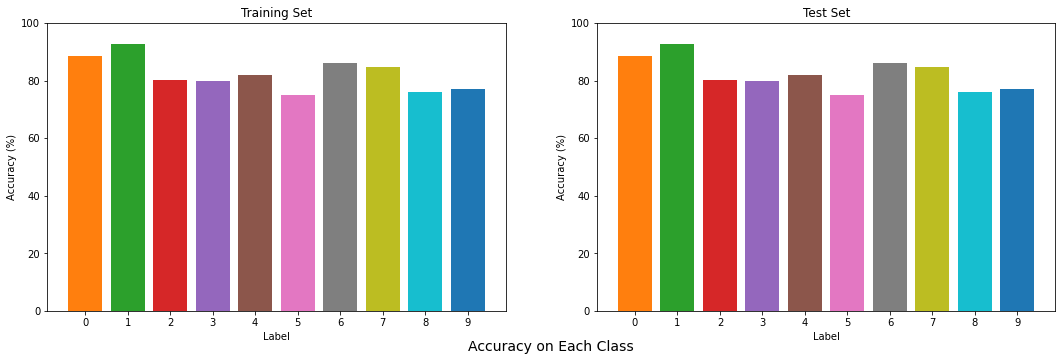

3.5655131340026855


In [52]:
start = time.time()
acc_train_list = cal_accuracy_class(model, train_x, train_y)*100
# acc_test_list = cal_accuracy_class(model, test_x, test_y)*100
plot_accuracy_class(acc_train_list, acc_train_list)
print(time.time() - start)

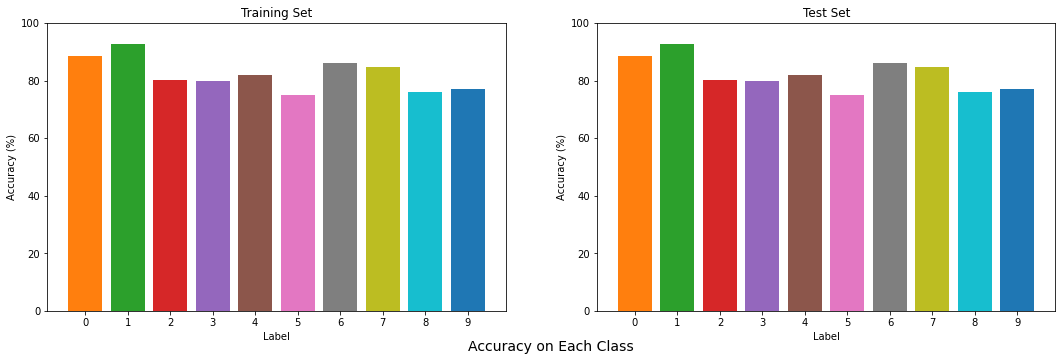

4.298662424087524


In [54]:
start = time.time()
acc_train_list = cal_accuracy_class(model, train_x, train_y)*100
# acc_test_list = cal_accuracy_class(model, test_x, test_y)*100
plot_accuracy_class(acc_train_list, acc_train_list)
print(time.time() - start)

### 5.2.3. Precision for Each Class

In [72]:
def cal_precision_class(model, data_x, data_y):
    pre_list = []
    for c in range(NUM_CLASS):
        data_x_cal = data_x[data_y == c]
        correct_count = 0
        FP_count = 0
        for i in range(len(data_x_cal)):
            predicted_class, _ = model.predict_class(data_x_cal[i].reshape(1, 784))
            correct_count += predicted_class == c   #TP
            
        for a in range(NUM_CLASS):
            if a==c: continue
            data_x_temp = data_x[data_y == a]
            
            for j in range(len(data_x_temp)):
                predicted_class, _ = model.predict_class(data_x_temp[j].reshape(1, 784))
                FP_count += predicted_class == c   #FP
                
        pre_list.append(correct_count/(correct_count+FP_count))
    return np.array(pre_list)

In [70]:
def cal_precision_class1(model, data_x, data_y, predicted_list):
    pre_list = []
    predicted_list = predicted(model, data_x)
    for c in range(NUM_CLASS):
        correct_count = 0
        FP_count = 0
        for i in range(len(data_y)):
            correct_count += ((data_y[i] == c) and (predicted_list[i] == c)) #TP
            FP_count += ((data_y[i] != c) and (predicted_list[i] == c)) #FP
                    
        pre_list.append(correct_count/(correct_count+FP_count))
    return np.array(pre_list)    

In [47]:
def plot_pre_class(acc_train_list, acc_test_list):
   
    # setup figure & axes
    subplot_kw=dict(xlabel='Label', ylabel='Precision (%)', ylim=(0, 100))
    gridspec_kw=dict(left=0, right=1, top=1, bottom=0, hspace=0.1)
    fig, axes = plt.subplots(nrows=1, ncols=2, subplot_kw=subplot_kw, gridspec_kw=gridspec_kw, figsize=(14, 4))
    
    # plot accuracies for training set
    axes[0].bar(np.arange(NUM_CLASS), acc_train_list, tick_label=np.arange(NUM_CLASS), color=COLOR_LIST)
    axes[0].set_title('Training Set')

    # plot accuracies for test set
    axes[1].bar(np.arange(NUM_CLASS), acc_test_list, tick_label=np.arange(NUM_CLASS), color=COLOR_LIST)
    axes[1].set_title('Test Set')
    
    fig.suptitle("Precision on Each Class", y=-0.1, fontsize=14)
    
    plt.show()

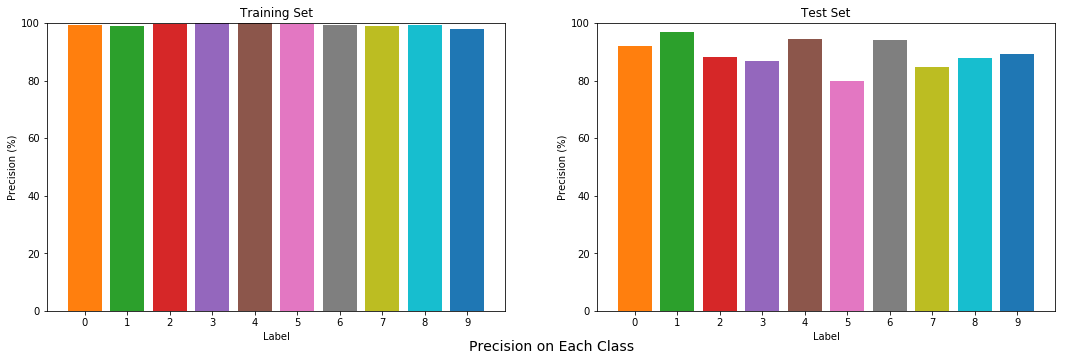

In [73]:
pre_train_list = cal_precision_class(model, train_x, train_y)*100
pre_test_list = cal_precision_class(model, test_x, test_y)*100
plot_pre_class(pre_train_list, pre_test_list)

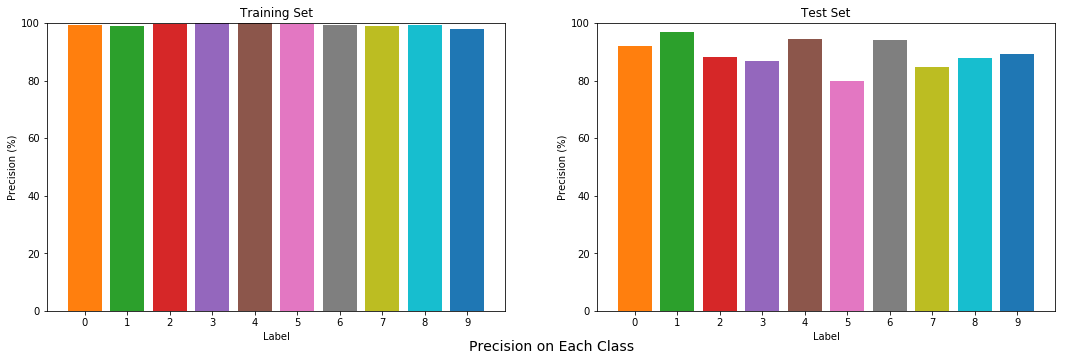

In [71]:
pre_train_list = cal_precision_class1(model, train_x, train_y, predicted_list)*100
pre_test_list = cal_precision_class1(model, test_x, test_y, predicted_list)*100
plot_pre_class(pre_train_list, pre_test_list)

### 5.2.4. Recall for Each Class

In [101]:
def cal_recall_class(model, data_x, data_y):
    re_list = []
    for c in range(NUM_CLASS):
        data_x_cal = data_x[data_y == c]
        correct_count = 0
        wrong_count = 0
        for i in range(len(data_x_cal)):
            predicted_class, _ = model.predict_class(data_x_cal[i].reshape(1, 784))
            correct_count += predicted_class == c   #TP
            wrong_count += predicted_class != c     #FN    
        re_list.append(correct_count/(correct_count+wrong_count))
    return np.array(re_list)

In [102]:
def plot_re_class(acc_train_list, acc_test_list):
   
    # setup figure & axes
    subplot_kw=dict(xlabel='Label', ylabel='Recall (%)', ylim=(0, 100))
    gridspec_kw=dict(left=0, right=1, top=1, bottom=0, hspace=0.1)
    fig, axes = plt.subplots(nrows=1, ncols=2, subplot_kw=subplot_kw, gridspec_kw=gridspec_kw, figsize=(14, 4))
    
    # plot Recall for training set
    axes[0].bar(np.arange(NUM_CLASS), acc_train_list, tick_label=np.arange(NUM_CLASS), color=COLOR_LIST)
    axes[0].set_title('Training Set')

    # plot Recall for test set
    axes[1].bar(np.arange(NUM_CLASS), acc_test_list, tick_label=np.arange(NUM_CLASS), color=COLOR_LIST)
    axes[1].set_title('Test Set')
    
    fig.suptitle("Recall on Each Class", y=-0.1, fontsize=14)
    
    plt.show()

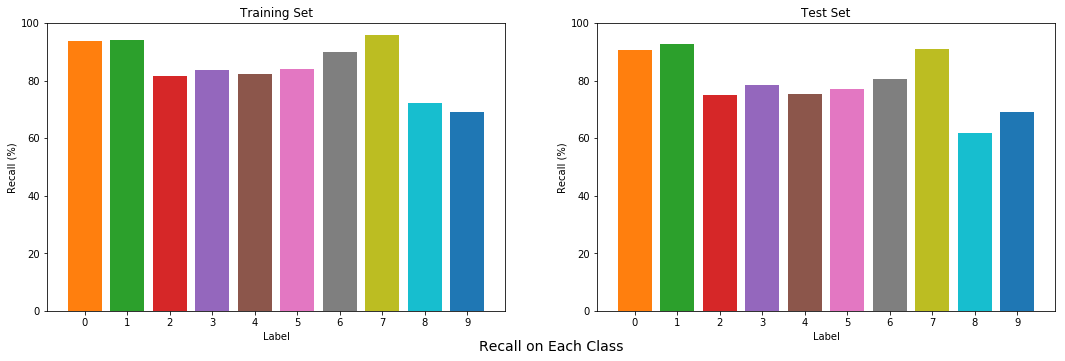

In [103]:
re_train_list = cal_recall_class(model, train_x, train_y)*100
re_test_list = cal_recall_class(model, test_x, test_y)*100
plot_re_class(re_train_list, re_test_list)

# END

In [16]:
import os
import glob
a = os.path.splitext('abc.def.gh.bz2')[0]


In [17]:
%cd C:/Users/letranquanghuy/OneDrive/CV Course/Module 3. Deep Learning/Project 3. NN - Dogs vs. Cats/data-raw/train
imgs_train = glob.glob('*.jpg')

C:\Users\letranquanghuy\OneDrive\CV Course\Module 3. Deep Learning\Project 3. NN - Dogs vs. Cats\data-raw\train


In [20]:
a = os.path.splitext(imgs_train [0])

In [37]:
a = imgs_train[0].split('.')[0]

In [38]:
a

'cat'

In [70]:
%cd C:/Users/letranquanghuy/OneDrive/CV Course/Module 3. Deep Learning/Project 3. NN - Dogs vs. Cats/data-raw/train_resize
imgs_train = glob.glob('*.jpg')
label = []
#Load label (cat = 1, dog = 2)
for i in range(num_train_load):
    if imgs_train[i].split('.')[0] == 'cat':
        label.append(1)
    else:
        label.append(2)
label = np.array(label)    

C:\Users\letranquanghuy\OneDrive\CV Course\Module 3. Deep Learning\Project 3. NN - Dogs vs. Cats\data-raw\train_resize


In [71]:
type(label_train[0])

int

In [72]:
label

array([1, 1, 1, ..., 1, 1, 1])

In [45]:
label

'cat'

In [37]:
hidden_layer_size = 100
layer_list = [784, hidden_layer_size, 2]
a = []
for i in range(len(layer_list)-1):
    a.append(np.random.rand(layer_list[i]+1, layer_list[i+1])*2-1)

In [42]:
a[0].shape


(785, 100)

In [43]:
a[1].shape

(101, 2)